# Figure 2. d) analysis

This notebook generates the networks used to create the Fig. 2 d) analysis. The visualization was done manually using Cytoscape and is not replicated here.

In [1]:
import json
import networkx as nx
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

Import networks, BIONIC features, and LSM2-7 complex results obtained from Fig. 2 c).

In [2]:
# import networks
net_names = ["Krogan-2006.txt", "Hu-2007.txt", "Costanzo-2016.txt"]
nets = [nx.read_weighted_edgelist(Path("../data/methods") / name) for name in net_names]

# import BIONIC features
features = pd.read_csv("../data/methods/yeast_BIONIC_features.csv", index_col=0)

# import protein complex results from Fig. 2 c) and subset to the LSM2-7 complex
complexes = pd.read_excel("../data/Modules_fig_2c.xlsx", sheet_name="IntAct")
lsm27 = complexes[complexes["Module Name"] == "LSM2-7 complex"]

# import gene ORF to gene name mapper
with Path("../data/chemical-genetics/yeast-orf2name-mapper.json").open("r") as f:
    orf2name_mapper = json.load(f)

# create a reverse gene name to ORF mapper as well
name2orf_mapper = {name: orf for orf, name in orf2name_mapper.items()}

Get the cluster from each network/features that matches the LSM2-7 complex.

In [3]:
nets_matching_clusters = [
    lsm27["Krogan (2006) Module Members"].item().split(" "),
    lsm27["Hu (2007) Module Members"].item().split(" "),
    lsm27["Costanzo (2016) Module Members"].item().split(" ")
]

features_matching_clusters = lsm27["BIONIC Module Members"].item().split(" ")

matching_clusters = nets_matching_clusters + [features_matching_clusters]

matching_clusters[-1]

['LSM1', 'LSM2', 'LSM3', 'LSM4', 'LSM6', 'LSM7', 'PAT1']

Map the cluster members from gene names to ORFs to match the input data (`nets` and `features`).

In [4]:
new_matching_clusters = []
for cluster in matching_clusters:
    mapped = [name2orf_mapper[name] if name in name2orf_mapper else name for name in cluster]
    new_matching_clusters.append(mapped)
matching_clusters = new_matching_clusters

matching_clusters[-1]

['YJL124C', 'YBL026W', 'YLR438C-A', 'YER112W', 'YDR378C', 'YNL147W', 'YCR077C']

Transform the BIONIC features into a network.

In [5]:
# first compute pairwise cosine similarities between genes
features_sim = pd.DataFrame(
    cosine_similarity(features.values), index=features.index, columns=features.index
)

# sparsify the complete graph by removing edges below 0.5 similarity
features_sim[features_sim < 0.5] = 0

# create a `networkx` object
features = nx.from_pandas_adjacency(features_sim)

Given the best matching LSM2-7 cluster for each network/features in `matching_clusters`, extract a subnetwork from each dataset that includes this cluster and its first order neighborhood.

In [6]:
datasets = nets + [features]

# create subnetworks
subnets = []
for cluster, dataset in zip(matching_clusters, datasets):

    # get neighborhood of `cluster`
    neighbors = []
    for gene in cluster:
        neighbors += dataset.neighbors(gene)
    
    # get subgraph
    subnet = dataset.subgraph(neighbors + cluster)
    subnets.append(subnet)

The networks in `subnets` correspond to the networks visualized in Fig. 2 d). We will use `networkx` to plot these networks in this notebook. The manuscript figure was created using Cytoscape.

<Figure size 432x288 with 0 Axes>

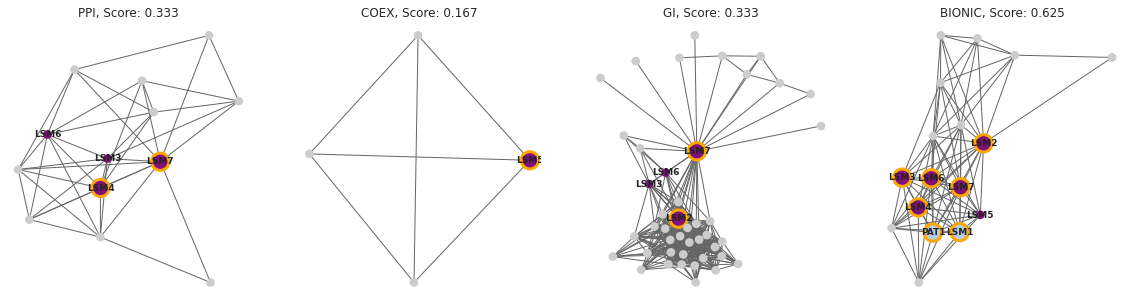

In [7]:
# get true LSM2-7 members
lsm27_members = lsm27["IntAct Complexes Module Members"].item().split(" ")
lsm27_members = [name2orf_mapper[name] if name in name2orf_mapper else name for name in lsm27_members]

# get overlap score for each network/features
scores = [
    lsm27["Krogan (2006) Score"].item(),
    lsm27["Hu (2007) Score"].item(),
    lsm27["Costanzo (2016) Score"].item(),
    lsm27["BIONIC Score"].item()
]

sns.set({"figure.facecolor": "white"})
sns.set_style("white")

plt.clf()
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for name, subnet, cluster, score, ax in zip(
    ["PPI", "COEX", "GI", "BIONIC"],
    subnets,
    matching_clusters,
    scores,
    axes
):
    
    # determine node colors, sizes and edge widths
    node_colors = []
    node_sizes = []
    node_widths = []
    for node in subnet.nodes():
        if node in lsm27_members:
            node_colors.append("#810f7c")
        elif node in cluster:
            node_colors.append("#b3cde3")
        else:
            node_colors.append("#cccccc")

        if node in cluster:
            node_sizes.append(300)
            node_widths.append(3)
        else:
            node_sizes.append(75)
            node_widths.append(0)

    # create node labels
    labels = {}
    for node in subnet.nodes():
        if node in lsm27_members or node in cluster:
            mapped_node = (
                orf2name_mapper[node] if node in orf2name_mapper else node
            )
            labels[node] = orf2name_mapper[node]
        
        # ignore genes not in LSM2-7 complex or best matching cluster
        else:
            labels[node] = ""
    
    # plot network
    nx.draw_networkx(
        subnet,
        pos=nx.spring_layout(subnet),
        ax=ax,
        node_size=node_sizes,
        node_color=node_colors,
        labels=labels,
        font_size=9,
        linewidths=node_widths,
        edgecolors="orange",
        font_weight="heavy",
        edge_color="#666666",
        font_color="#222222",
    )
    ax.set_title(f"{name}, Score: {score}")
    ax.axis("off")
